In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [23]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

In [4]:
detox_en2ru = pd.read_csv('detox_en2ru_yandex.tsv', sep='\t')

and the guards will get fucked


In [2]:
from transformers import M2M100ForConditionalGeneration, M2M100Tokenizer

model = M2M100ForConditionalGeneration.from_pretrained("facebook/m2m100_418M")
tokenizer = M2M100Tokenizer.from_pretrained("facebook/m2m100_418M")

In [10]:
model.cuda();

In [11]:
import torch

In [33]:
text = detox_en2ru.sample(1).toxic_comment.iloc[0]
print(text)

they 've simply cried wolf too many times , and now it 's biting them in the ass .


In [51]:
tokenizer.src_lang = "en"
batch = tokenizer(text, return_tensors="pt")

In [104]:
tokenizer.convert_ids_to_tokens(batch['input_ids'][0])

['__ru__',
 '▁Это',
 '▁ло',
 'ж',
 'ь',
 ',',
 '▁я',
 '▁к',
 'ля',
 'ну',
 'сь',
 ',',
 '▁sm',
 'h',
 '▁w',
 '</s>']

In [52]:
with torch.inference_mode():
    encoded = model.model.encoder(**batch.to(model.device))

In [53]:
generated_tokens = model.generate(encoder_outputs=encoded, forced_bos_token_id=tokenizer.get_lang_id("en"))
tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)

['They’ve simply cried wolf too many times, and now it’s biteing them in the ass.']

# Exploring the cross-lingual space

In [20]:
sample = detox_en2ru.sample(50, random_state=1)

In [61]:
cc = ['toxic_comment', 'neutral_comment', 'toxic_ru', 'neutral_ru']
embs = {c: [] for c in cc}
for c in cc:
    lang = 'ru' if c.endswith('ru') else 'en'
    tokenizer.src_lang = lang
    for text in tqdm(sample[c]):
        batch = tokenizer(text, return_tensors="pt")
        with torch.inference_mode():
            encoded = model.model.encoder(**batch.to(model.device))
        embs[c].append(encoded.last_hidden_state[0].cpu().numpy())

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [113]:
embs_list = []
colors = []
for i, c in enumerate(embs):
    for emb in embs[c]:
        embs_list.append(emb[1:-1])
        colors.extend([i] * (emb.shape[0]-2))
embs_list = np.concatenate(embs_list)
colors = np.array(colors)
print(embs_list.shape)
print(len(colors))

(2978, 1024)
2978


In [106]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

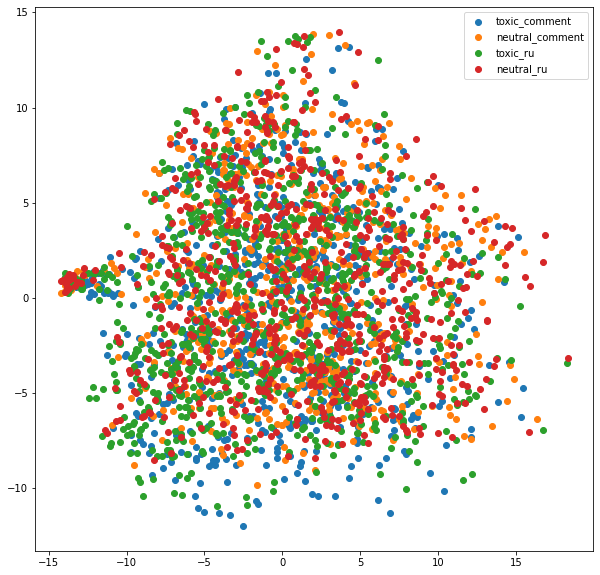

In [108]:
pca = PCA(n_components=2)
embs2 = pca.fit_transform(embs_list)

plt.figure(figsize=(10,10))

for i, c in enumerate(cc):
    f = (np.array(colors)==i)
    plt.scatter(embs2[f, 0], embs2[f, 1]);
plt.legend(cc);

In [109]:
pca = TSNE(n_components=2, learning_rate=100, init='random')
embs2 = pca.fit_transform(embs_list)

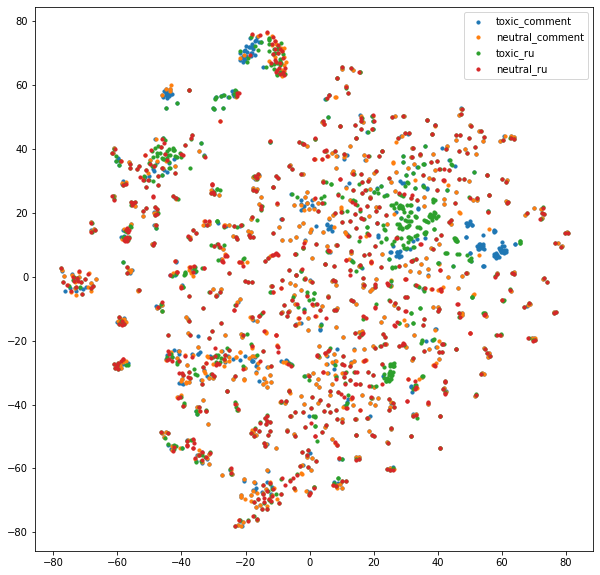

In [120]:
plt.figure(figsize=(10,10))

for i, c in enumerate(cc):
    f = (np.array(colors)==i)
    plt.scatter(embs2[f, 0], embs2[f, 1], s=10);
plt.legend(cc);

In [115]:
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [114]:
print(cross_val_score(LogisticRegression(max_iter=1000), embs_list, colors, cv=KFold(3, shuffle=True, random_state=1)))

[0.64149043 0.67774421 0.68245968]


In [116]:
preds = cross_val_predict(LogisticRegression(max_iter=1000), embs_list, colors, cv=KFold(3, shuffle=True, random_state=1))

In [117]:
print(confusion_matrix(colors, preds))

[[512 172  40   5]
 [159 414   3  31]
 [ 27   7 620 256]
 [  5  26 260 441]]


Judging by the confusion matrix, a logistic regression can more or less easily classify the language, but not toxicity by the embeddings. 

However, even for toxicity there is high discriminative power. This means that some dimension in the embeddings may be responsible for toxicity.

# Training an adapter

In [131]:
from sklearn.model_selection import train_test_split
train, dev = train_test_split(detox_en2ru, test_size=0.1, random_state=1)

In [358]:
hidden_dim = 1024
internal_dim = 4096

In [411]:
class Adapter(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.delta = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.delta = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, internal_dim, bias=True),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(internal_dim, hidden_dim, bias=True),
        )
    def forward(self, x):
        return x + self.delta(x)
    
adapter = Adapter()

In [412]:
adapter.cuda()

Adapter(
  (delta): Sequential(
    (0): Linear(in_features=1024, out_features=4096, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=4096, out_features=1024, bias=True)
  )
)

In [413]:
model.train()
adapter.train()

Adapter(
  (delta): Sequential(
    (0): Linear(in_features=1024, out_features=4096, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=4096, out_features=1024, bias=True)
  )
)

In [414]:
optimizer = torch.optim.Adam(adapter.parameters(), lr=5e-5)

In [415]:
losses = []
for i in trange(5_000):
    text_batch = train.sample(16)
    tokenizer.src_lang = "en"
    batch_in = tokenizer(text_batch.toxic_comment.tolist(), return_tensors="pt", padding=True).to(model.device)
    batch_out = tokenizer(text_batch.neutral_comment.tolist(), return_tensors="pt", padding=True).to(model.device)
    batch_out.input_ids[batch_out.input_ids==tokenizer.pad_token_id] = -100
    
    with torch.no_grad():
        encoded = model.model.encoder(**batch_in)
    transformed = adapter(encoded.last_hidden_state)

    total_out = model(
        encoder_outputs=[transformed], 
        attention_mask=batch_in.attention_mask,
        decoder_attention_mask=batch_out.attention_mask,
        labels=batch_out.input_ids,
    )
    total_out.loss.backward()
    torch.nn.utils.clip_grad_norm_(adapter.parameters(), 1.0)
    optimizer.step()
    optimizer.zero_grad()
    losses.append(total_out.loss.item())
    if i % 100 == 0:
        print(np.mean(losses[-100:]))


  0%|          | 0/5000 [00:00<?, ?it/s]

2.5634987354278564
1.4070603054761888
1.3360754132270813
1.2615285867452621
1.2275899678468705
1.1670683205127717
1.2174230057001114
1.1401446628570557
1.163581547141075
1.12140034198761
1.1180261158943177
1.1152860122919082
1.0788375097513199
1.0816934752464293
1.0830440497398377
1.079659610390663
1.0200724989175796
1.0480930799245833
1.0719901514053345
1.0440519952774048
1.047811543941498
1.031197504401207
1.0311361509561539
1.0021490502357482
0.9938245511054993
0.976237244606018
1.0152997434139253
1.019503903388977
0.9699429994821549
0.9703399401903152
0.9965122258663177
1.0081796833872796
0.9662356829643249
0.9710186213254929
0.971836371421814
0.9582587611675263
0.9479912170767784
0.9900373417139053
0.9948910355567933
0.9476789581775665
0.938176862001419
0.941300117969513
0.9648290997743607
0.9473976528644562
0.95912745565176
0.9682060080766678
0.9274116313457489
0.9024239045381546
0.9334097623825073
0.9124724984169006


In [416]:
model.eval();
adapter.eval();

In [417]:
row = detox_en2ru.sample(1).iloc[0]
text = row.toxic_comment
print(text)
print(row.neutral_comment)

i think you are fine as fuck 59
I think you are fine.


In [418]:
tokenizer.src_lang = "en"
batch = tokenizer(text, return_tensors="pt").to(model.device)
with torch.inference_mode():
    encoded = model.model.encoder(**batch)
generated_tokens = model.generate(encoder_outputs=encoded, forced_bos_token_id=tokenizer.get_lang_id("en"))
print(tokenizer.batch_decode(generated_tokens, skip_special_tokens=True))

['I think you’re fine as fuck 59']


In [419]:
from transformers.modeling_outputs import BaseModelOutput

In [420]:
with torch.inference_mode():
    encoded = model.model.encoder(**batch)
    adapted = BaseModelOutput(last_hidden_state=adapter(encoded.last_hidden_state))
generated_tokens = model.generate(encoder_outputs=adapted, forced_bos_token_id=tokenizer.get_lang_id("en"))
print(tokenizer.batch_decode(generated_tokens, skip_special_tokens=True))

['I think you are fine.']


In [421]:
print(row.toxic_ru)
print(row.neutral_ru)

tokenizer.src_lang = "ru"
batch = tokenizer(row.toxic_ru, return_tensors="pt").to(model.device)
with torch.inference_mode():
    encoded = model.model.encoder(**batch)
generated_tokens = model.generate(encoder_outputs=encoded, forced_bos_token_id=tokenizer.get_lang_id("ru"))
print(tokenizer.batch_decode(generated_tokens, skip_special_tokens=True))

with torch.inference_mode():
    encoded = model.model.encoder(**batch)
    adapted = BaseModelOutput(last_hidden_state=adapter(encoded.last_hidden_state))
generated_tokens = model.generate(encoder_outputs=adapted, forced_bos_token_id=tokenizer.get_lang_id("ru"))
print(tokenizer.batch_decode(generated_tokens, skip_special_tokens=True))

я думаю, что ты чертовски хороша.
Я думаю, с тобой все в порядке.
['Я думаю, что ты чертовски хорошая.']
['Я думаю, что вы хороши.']


Does beam search work in this mode?

In [425]:
with torch.inference_mode():
    encoded = model.model.encoder(**batch)
    adapted = BaseModelOutput(last_hidden_state=adapter(encoded.last_hidden_state))
generated_tokens = model.generate(encoder_outputs=adapted, forced_bos_token_id=tokenizer.get_lang_id("ru"), num_beams=3, num_return_sequences=3)
print(tokenizer.batch_decode(generated_tokens, skip_special_tokens=True))

['Я думаю, что вы хороши.', 'Я думаю, что ты хорош.', 'Я думаю, что ты хороша.']


The results seem to indicate that the adapter works fine (at least, for English).

In Russian the encoder-decoder itself is rather poor (even without the adapter), so it's difficult to properly compare texts with and without the adapter. Probably, the model has seen very few Russian toxic texts. 

In [442]:
def paraphrase_adapt(
    text, model, tokenizer, adapter,
    n=None, 
    max_length="auto", 
    beams=5,
    src_lang='en',
    tgt_lang='en',
    **kwargs
):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    texts = [text] if isinstance(text, str) else text
    tokenizer.tgt_lang
    inputs = tokenizer(texts, return_tensors="pt", padding=True)["input_ids"].to(model.device)

    if max_length == "auto":
        max_length = inputs.shape[1] + 10
        
    with torch.inference_mode():
        encoded = model.model.encoder(inputs)
        adapted = BaseModelOutput(last_hidden_state=adapter(encoded.last_hidden_state))

    result = model.generate(
        encoder_outputs=adapted,
        num_return_sequences=n or 1,
        do_sample=False,
        temperature=1.0,
        repetition_penalty=1.0,
        max_length=max_length,
        #min_length=int(0.5 * max_length),
        num_beams=beams,
        forced_bos_token_id=tokenizer.get_lang_id(tgt_lang),
    )
    texts = [tokenizer.decode(r, skip_special_tokens=True) for r in result]

    if not n and isinstance(text, str):
        return texts[0]
    return texts[0]

In [448]:
paraphrase_adapt(row.toxic_comment, model, tokenizer, adapter, src_lang='en', tgt_lang='en', beams=5)

'I think you are fine.'

In [449]:
paraphrase_adapt(row.toxic_ru, model, tokenizer, adapter, src_lang='ru', tgt_lang='ru', beams=5)

'Я думаю, что вы хороши.'

# Evaluating the model on English and Russian

In [450]:
test_data = pd.read_csv('../data/russian_data/test.tsv', sep='\t')
test_inputs_ru = test_data["toxic_comment"].values.tolist()

In [451]:
with open('../data/english_data/test_toxic_parallel.txt', 'r') as f:
    test_inputs_en = [line.strip() for line in f.readlines()]

In [454]:
test_outputs_ru = [paraphrase_adapt(text, model, tokenizer, adapter, src_lang='ru', tgt_lang='ru') for text in tqdm(test_inputs_ru)]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [455]:
test_outputs_en = [paraphrase_adapt(text, model, tokenizer, adapter, src_lang='en', tgt_lang='en') for text in tqdm(test_inputs_en)]

  0%|          | 0/671 [00:00<?, ?it/s]

In [459]:
path = '../results/enc_adapter_m2m_v1/' 
if not os.path.exists(path):
    os.mkdir(path)

In [460]:
with open(path + 'results_ru.txt', 'w') as f:
    for line in test_outputs_ru:
        f.write(line + '\n')
with open(path + 'results_en.txt', 'w') as f:
    for line in test_outputs_en:
        f.write(line + '\n')

```
cd /home/dale/projects/multilingual_detox$
python evaluate_ru.py \
    --result_filename scores \
    --input_dir results/enc_adapter_m2m_v1\
    --output_dir results
    
Style accuracy:       0.3578416109085083
Meaning preservation: 0.876542329788208
Joint fluency:        -0.22605130076408386
Joint score:          -0.07532332837581635
Scores after calibration:
Style accuracy:       0.4220574200153351
Meaning preservation: 0.814909040927887
Joint fluency:        0.7400410175323486
Joint score:          0.23157751560211182
```

```
cd /home/dale/projects/paradetox2/evaluation_detox
python metric.py --inputs /home/dale/projects/multilingual_detox/data/english_data/test_toxic_parallel.txt \
    --preds /home/dale/projects/multilingual_detox/results/enc_adapter_m2m_v1/results_en.txt \
    --cola_classifier_path /home/dale/models/cola_classifier_fairseq \
    --wieting_model_path /home/dale/models/wieting_similarity/sim.pt \
    --wieting_tokenizer_path /home/dale/models/wieting_similarity/sim.sp.30k.model \
    --batch_size 32
cat results.md
```


| Model | ACC | EMB_SIM | SIM | CharPPL | TokenPPL | FL | GM | J | BLEU |
| ----- | --- | ------- | --- | ------- | -------- | -- | -- | - | ---- |
results_en.txt|0.8823|0.8714|0.8540|6.1855|169.6834|0.8018|10.9636|0.5992|0.6873|

# The same from Russian to English

In [461]:
detox_ru2en = pd.read_csv('detox_ru2en_yandex.tsv', sep='\t')

In [465]:
from sklearn.model_selection import train_test_split
train_ru, dev_ru = train_test_split(detox_ru2en, test_size=0.1, random_state=1)

In [462]:
class Adapter(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # self.delta = torch.nn.Linear(hidden_dim, hidden_dim, bias=True)
        self.delta = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, internal_dim, bias=True),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(internal_dim, hidden_dim, bias=True),
        )
    def forward(self, x):
        return x + self.delta(x)
    
adapter = Adapter()

In [463]:
adapter.cuda()
model.train()
adapter.train()

Adapter(
  (delta): Sequential(
    (0): Linear(in_features=1024, out_features=4096, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=4096, out_features=1024, bias=True)
  )
)

In [464]:
optimizer = torch.optim.Adam(adapter.parameters(), lr=5e-5)

In [469]:
losses = []
for i in trange(5_000):
    text_batch = train_ru.sample(16)
    tokenizer.src_lang = "ru"
    batch_in = tokenizer(text_batch.toxic_comment.tolist(), return_tensors="pt", padding=True).to(model.device)
    batch_out = tokenizer(text_batch.neutral_comment.tolist(), return_tensors="pt", padding=True).to(model.device)
    batch_out.input_ids[batch_out.input_ids==tokenizer.pad_token_id] = -100
    
    with torch.no_grad():
        encoded = model.model.encoder(**batch_in)
    transformed = adapter(encoded.last_hidden_state)

    total_out = model(
        encoder_outputs=[transformed], 
        attention_mask=batch_in.attention_mask,
        decoder_attention_mask=batch_out.attention_mask,
        labels=batch_out.input_ids,
    )
    total_out.loss.backward()
    torch.nn.utils.clip_grad_norm_(adapter.parameters(), 1.0)
    optimizer.step()
    optimizer.zero_grad()
    losses.append(total_out.loss.item())
    if i % 100 == 0:
        print(np.mean(losses[-100:]))


  0%|          | 0/5000 [00:00<?, ?it/s]

2.631380558013916
1.8291556024551392
1.7175639498233795
1.648769612312317
1.6000896215438842
1.5719745647907257
1.553817673921585
1.5003490084409714
1.4735709202289582
1.4521545922756196
1.4470580911636353
1.3713333696126937
1.4275887823104858
1.4252421069145202
1.3495681178569794
1.3930291259288787
1.3639051175117494
1.317433986067772
1.3011553514003753
1.2805357027053832
1.3000883591175079
1.2805873811244965
1.3277544993162156
1.274260586500168
1.2187326097488402
1.2610088592767716
1.280088717341423
1.2426704108715056
1.2178884774446488
1.2022328579425812
1.205472731590271
1.1543121647834778
1.146701963543892
1.159218320250511
1.1610113954544068
1.1521431916952134
1.1543904840946198
1.1279992699623107
1.1310696691274642
1.105640343427658
1.115395388007164
1.1199989646673203
1.080798503756523
1.1286238706111908
1.0576503676176072
1.0930170965194703
1.0700987058877944
1.0724241143465043
1.0330705851316453
1.0622481197118758


In [478]:
model.eval();
adapter.eval();

In [470]:
test_data = pd.read_csv('../data/russian_data/test.tsv', sep='\t')
test_inputs_ru = test_data["toxic_comment"].values.tolist()

In [471]:
with open('../data/english_data/test_toxic_parallel.txt', 'r') as f:
    test_inputs_en = [line.strip() for line in f.readlines()]

In [479]:
test_outputs_ru = [paraphrase_adapt(text, model, tokenizer, adapter, src_lang='ru', tgt_lang='ru') for text in tqdm(test_inputs_ru)]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [480]:
test_outputs_en = [paraphrase_adapt(text, model, tokenizer, adapter, src_lang='en', tgt_lang='en') for text in tqdm(test_inputs_en)]

  0%|          | 0/671 [00:00<?, ?it/s]

In [481]:
path = '../results/enc_adapter_m2m_ru_v1/' 
if not os.path.exists(path):
    os.mkdir(path)

In [482]:
with open(path + 'results_ru.txt', 'w') as f:
    for line in test_outputs_ru:
        f.write(line + '\n')
with open(path + 'results_en.txt', 'w') as f:
    for line in test_outputs_en:
        f.write(line + '\n')

```
cd /home/dale/projects/multilingual_detox
python evaluate_ru.py \
    --result_filename scores \
    --input_dir results/enc_adapter_m2m_ru_v1\
    --output_dir results
    
Style accuracy:       0.7373876571655273
Meaning preservation: 0.852652907371521
Joint fluency:        -0.19969893991947174
Joint score:          -0.11836094409227371
Scores after calibration:
Style accuracy:       0.7636488676071167
Meaning preservation: 0.7790086269378662
Joint fluency:        0.7703461647033691
Joint score:          0.46733611822128296
```

```
cd /home/dale/projects/paradetox2/evaluation_detox
python metric.py --inputs /home/dale/projects/multilingual_detox/data/english_data/test_toxic_parallel.txt \
    --preds /home/dale/projects/multilingual_detox/results/enc_adapter_m2m_ru_v1/results_en.txt \
    --cola_classifier_path /home/dale/models/cola_classifier_fairseq \
    --wieting_model_path /home/dale/models/wieting_similarity/sim.pt \
    --wieting_tokenizer_path /home/dale/models/wieting_similarity/sim.sp.30k.model \
    --batch_size 32
cat results.md
```


| Model | ACC | EMB_SIM | SIM | CharPPL | TokenPPL | FL | GM | J | BLEU |
| ----- | --- | ------- | --- | ------- | -------- | -- | -- | - | ---- |
results_en.txt|0.4203|0.8633|0.8932|6.2777|142.1785|0.8167|0.0000|0.2741|0.7448|

# Experiments with style strength

In [483]:
def paraphrase_adapt(
    text, model, tokenizer, adapter,
    coef=1,
    n=None, 
    max_length="auto", 
    beams=5,
    src_lang='en',
    tgt_lang='en',
    **kwargs
):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    texts = [text] if isinstance(text, str) else text
    tokenizer.tgt_lang
    inputs = tokenizer(texts, return_tensors="pt", padding=True)["input_ids"].to(model.device)

    if max_length == "auto":
        max_length = inputs.shape[1] + 10
        
    with torch.inference_mode():
        encoded = model.model.encoder(inputs)
        old_states = encoded.last_hidden_state
        new_states = adapter(encoded.last_hidden_state)
        interpolated = old_states + coef * (new_states - old_states)
        adapted = BaseModelOutput(last_hidden_state=interpolated)

    result = model.generate(
        encoder_outputs=adapted,
        num_return_sequences=n or 1,
        do_sample=False,
        temperature=1.0,
        repetition_penalty=1.0,
        max_length=max_length,
        #min_length=int(0.5 * max_length),
        num_beams=beams,
        forced_bos_token_id=tokenizer.get_lang_id(tgt_lang),
    )
    texts = [tokenizer.decode(r, skip_special_tokens=True) for r in result]

    if not n and isinstance(text, str):
        return texts[0]
    return texts[0]

In [511]:
row = detox_ru2en.sample(1).iloc[0]
text = row.toxic_comment
print(text)
print(row.neutral_comment)

к чему твоя пикча, дурачок? этот чувак не из Украины, а откудо-то из Сибири вроде Омск...
К чему твоя Пикча? Этот чувак не из Украины, а откуда-то из Сибири вроде Омск


In [512]:
for coef in [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5]:
    print(coef, '\t', paraphrase_adapt(text, model, tokenizer, adapter, coef=coef, src_lang='ru', tgt_lang='ru'))

0 	 К чему твоя пикча, глупак? этот чувак не из Украины, а откуда-то из Сибири как Омск...
0.25 	 К чему твоя пикча, глупак? этот чувак не из Украины, а откуда-то из Сибири как Омск...
0.5 	 К чему твоя пикча? этот чувак не из Украины, а откуда-то из Сибири вроде Омск...
0.75 	 К чему твоя пикча? Этот чувак не из Украины, а откуда-то из Сибири вроде Омск...
1 	 К чему твоя пикча? Этот человек не из Украины, а откуда-то из Сибири вроде Омск...
1.25 	 К чему ты пикча? Этот человек не из Украины, а откуда то то из Сибири вроде Омск...
1.5 	 К чему ты говоришь? Этот человек не из Украины, а от Сбири вроде Омск...


Occasionally, coefficient of 1 does not fully detoxify, but 1.25 or 1.5 does. But it's not obvious how to predict which coefficient is enough.

In [550]:
row = detox_en2ru.sample(1).iloc[0]
text = row.toxic_comment
print(text)
print(row.neutral_comment)

for coef in [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]:
    print(coef, '\t', paraphrase_adapt(text, model, tokenizer, adapter, coef=coef, src_lang='en', tgt_lang='en'))

all for immigration but europe 's gone to shit over the last decade .
All for immigration but Europe is not so strong over the last decade.
0 	 All for immigration but Europe’s gone to shit over the last decade.
0.25 	 All for immigration but Europe’s gone to shit over the last decade.
0.5 	 All for immigration but Europe’s gone to shit over the last decade.
0.75 	 All for immigration but Europe’s gone to shit over the last decade.
1 	 All for immigration but Europe's have gone to shit over the last decade.
1.25 	 All for immigration but Europe's have gone to shit over the last decade.
1.5 	 All for immigration but Europe's have gone to it in the last decade
1.75 	 All for immigration but Europe's have gone to it.
2 	 in Europa's'd'd'd'd'd'd'd'd'd'd'd'


In [560]:
smoothed_en = []

for coef in tqdm([0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2]):
    dev_smooth = pd.DataFrame({'toxic': dev['toxic_comment'], 'neutral': dev['neutral_comment']})
    outs = []
    for text in tqdm(dev_smooth.toxic):
        outs.append(paraphrase_adapt(text, model, tokenizer, adapter, coef=coef, src_lang='en', tgt_lang='en'))
    dev_smooth['coef'] = coef
    dev_smooth['rewritten'] = outs
    smoothed_en.append(dev_smooth)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1977 [00:00<?, ?it/s]

  0%|          | 0/1977 [00:00<?, ?it/s]

  0%|          | 0/1977 [00:00<?, ?it/s]

  0%|          | 0/1977 [00:00<?, ?it/s]

  0%|          | 0/1977 [00:00<?, ?it/s]

  0%|          | 0/1977 [00:00<?, ?it/s]

  0%|          | 0/1977 [00:00<?, ?it/s]

  0%|          | 0/1977 [00:00<?, ?it/s]

  0%|          | 0/1977 [00:00<?, ?it/s]

In [563]:
len(smoothed_en)

9

In [570]:
smoothed_en_total = pd.concat(smoothed_en)

In [571]:
smoothed_en_total

,toxic,neutral,coef,rewritten
16603,take your arrogant ass and fuck,Go away,0.0,Take your arrogant ass and fuck
11370,as well as routinely test for a whole host of ...,as well as routinely test for a whole host of ...,0.0,as well as routine testing for a whole range o...
741,"youre asking to be reprimanded , dumbass .",You're asking to be reprimanded.,0.0,"You are asking to be reprimanded, dumbass."
9679,i 've noticed we use the same words dick < 1 b...,i 've noticed we use the same words < 1 but i ...,0.0,I've noticed we use the same words dick < 1 bu...
13433,what the fuck is going on in france ? ! ? ! ?,What is going on in France?,0.0,What the fuck is going on in France?
...,...,...,...,...
11872,you signed up for that shit .,you enlisted youself in that.,2.0,You did not know what you do?
612,"please stop idiot user : j milburn , who is a ...",Please stop user j milburn who deletes pictures,2.0,Please use
4485,and my insurance sucks so it is a bitch to go ...,and my insurance is to go to another one .,2.0,And my insurance does not have anything to do.
1362,"who said shes privilege because shes black , t...",Are you saying she's privileged just because s...,2.0,who said privilege has no one.


In [567]:
import sys
sys.path.append(os.path.abspath('..'))

In [585]:
from importlib import reload
import evaluate_ru
reload(evaluate_ru)

<module 'evaluate_ru' from '/home/dale/projects/multilingual_detox/evaluate_ru.py'>

In [586]:
from evaluate_ru import evaluate_style_transfer, rotation_calibration, load_model
from transformers import AutoModel

In [574]:
style_model, style_tokenizer = load_model(
    "SkolkovoInstitute/roberta_toxicity_classifier", use_cuda=True
)
meaning_model, meaning_tokenizer = load_model(
    "cointegrated/LaBSE-en-ru", use_cuda=True, model_class=AutoModel
)
cola_model, cola_tolenizer = load_model(
    "cointegrated/roberta-large-cola-krishna2020", use_cuda=True
)

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at cointegrated/LaBSE-en-ru were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias

In [587]:
def evaluate(original, rewritten):
    return evaluate_style_transfer(
        original_texts=original,
        rewritten_texts=rewritten,
        style_model=style_model,
        style_tokenizer=style_tokenizer,
        meaning_model=meaning_model,
        meaning_tokenizer=meaning_tokenizer,
        cola_model=cola_model,
        cola_tokenizer=cola_tolenizer,
        style_target_label=0,
        aggregate=False,
    )

In [588]:
evaluate(smoothed_en_total.toxic.tolist()[:10], smoothed_en_total.rewritten.tolist()[:10])

Style evaluation


  0%|          | 0/1 [00:00<?, ?it/s]

Meaning evaluation


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Fluency evaluation


  0%|          | 0/1 [00:00<?, ?it/s]

Style accuracy:       0.004463329911231995
Meaning preservation: 0.9362119436264038
Joint fluency:        0.08587229251861572
Joint score:          0.00044021764188073575


{'accuracy': array([0.0004008 , 0.00883438, 0.00068814, 0.00612737, 0.00194569,
        0.01342269, 0.0043384 , 0.00113114, 0.00642065, 0.00132404],
       dtype=float32),
 'similarity': array([0.95715904, 0.9586289 , 0.9720336 , 0.9952499 , 0.7581826 ,
        0.9272719 , 0.96986175, 0.9313241 , 0.96922874, 0.9231801 ],
       dtype=float32),
 'fluency': array([0.03017178, 0.01991601, 0.00738973, 0.3300919 , 0.00661241,
        0.01352297, 0.31790042, 0.00741753, 0.10535672, 0.02034353],
       dtype=float32),
 'joint': array([1.15747725e-05, 1.68666476e-04, 4.94293090e-06, 2.01298692e-03,
        9.75457260e-06, 1.68313447e-04, 1.33761333e-03, 7.81408198e-06,
        6.55643584e-04, 2.48664419e-05], dtype=float32)}

In [589]:
eval_result = evaluate(smoothed_en_total.toxic.tolist(), smoothed_en_total.rewritten.tolist())

Style evaluation


  0%|          | 0/557 [00:00<?, ?it/s]

Meaning evaluation


  0%|          | 0/557 [00:00<?, ?it/s]

  0%|          | 0/557 [00:00<?, ?it/s]

Fluency evaluation


  0%|          | 0/557 [00:00<?, ?it/s]

Style accuracy:       0.48484891653060913
Meaning preservation: 0.8035171031951904
Joint fluency:        0.29191556572914124
Joint score:          0.11001109331846237


In [590]:
eval_result

{'accuracy': array([4.0079976e-04, 8.8343890e-03, 6.8813737e-04, ..., 9.9995899e-01,
        9.9995351e-01, 9.9994898e-01], dtype=float32),
 'similarity': array([0.95715904, 0.9586289 , 0.97203356, ..., 0.5525099 , 0.4865151 ,
        0.69176537], dtype=float32),
 'fluency': array([0.03017175, 0.01991601, 0.00738972, ..., 0.20316884, 0.2431058 ,
        0.2750421 ], dtype=float32),
 'joint': array([1.15747616e-05, 1.68666709e-04, 4.94292772e-06, ...,
        1.12248197e-01, 1.18269145e-01, 1.90254882e-01], dtype=float32)}

In [591]:
pd.Series(eval_result['fluency']).describe()

count    17793.000000
mean         0.291916
std          0.335477
min          0.003700
25%          0.013892
50%          0.111475
75%          0.541397
max          0.993652
dtype: float64

In [599]:
scored = pd.concat([smoothed_en_total.reset_index(drop=True), pd.DataFrame(eval_result)], axis=1)

In [604]:
from sacrebleu import CHRF

In [605]:
chrf_scorer = CHRF()

59.65445995185393

In [618]:
chrf_dep = scored.groupby('coef').apply(lambda x: chrf_scorer.corpus_score(x.rewritten.tolist(), [x.neutral.tolist()]).score)
chrf_dep

coef
0.00    67.379976
0.25    68.228197
0.50    68.677478
0.75    68.817859
1.00    67.625447
1.25    63.810313
1.50    55.527597
1.75    43.782496
2.00    30.211360
dtype: float64

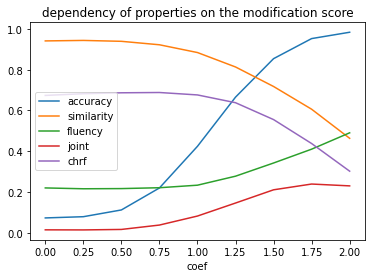

In [620]:
means = scored.groupby('coef').mean()
means['chrf'] = chrf_dep / 100
means.plot(title='dependency of properties on the modification score');

In [621]:
print(means)

      accuracy  similarity   fluency     joint      chrf
coef                                                    
0.00  0.072764    0.941305  0.219960  0.014325  0.673800
0.25  0.078802    0.943689  0.215839  0.013954  0.682282
0.50  0.111914    0.939319  0.216722  0.016290  0.686775
0.75  0.219769    0.922361  0.220954  0.037799  0.688179
1.00  0.424197    0.884236  0.233416  0.082025  0.676254
1.25  0.665420    0.813468  0.277568  0.145863  0.638103
1.50  0.854213    0.717694  0.342260  0.210770  0.555276
1.75  0.952728    0.606150  0.410117  0.239044  0.437825
2.00  0.983833    0.463433  0.490402  0.230029  0.302114


In [622]:
scored.to_csv('m2m_token_mapping_dev_en_scored.csv', index=None)